# Logistic Regression model to predict the inflection curve of COVID-19 in U.S

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from datetime import datetime,timedelta
from scipy.optimize import fsolve

In [2]:
# load data from JHU CSSE 
# https://github.com/CSSEGISandData/COVID-19
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_confirmed=pd.read_csv(url_confirmed, index_col=[0,1,2,3])
df_confirmed

1/22/20  1/23/20  \
Province/State Country/Region     Lat        Long                           
NaN            Afghanistan         33.939110  67.709953        0        0   
               Albania             41.153300  20.168300        0        0   
               Algeria             28.033900  1.659600         0        0   
               Andorra             42.506300  1.521800         0        0   
               Angola             -11.202700  17.873900        0        0   
...                                                          ...      ...   
               West Bank and Gaza  31.952200  35.233200        0        0   
               Western Sahara      24.215500 -12.885800        0        0   
               Yemen               15.552727  48.516388        0        0   
               Zambia             -13.133897  27.849332        0        0   
               Zimbabwe           -19.015438  29.154857        0        0   

                                                         1/24/20  1/25/20  \
Province/State Country/Region     Lat        Long                           
NaN            Afghanistan         33.939110  67.709953        0        0   
               Albania             41.153300  20.168300        0        0   
               Algeria             28.033900  1.659600         0        0   
               Andorra             42.506300  1.521800         0        0   
               Angola             -11.202700  17.873900        0        0   
...                                                          ...      ...   
               West Bank and Gaza  31.952200  35.233200        0        0   
               Western Sahara      24.215500 -12.885800        0        0   
               Yemen               15.552727  48.516388        0        0   
               Zambia             -13.133897  27.849332        0        0   
               Zimbabwe           -19.015438  29.154857        0        0   

                                                         1/26/20  1/27/20  \
Province/State Country/Region     Lat        Long                           
NaN            Afghanistan         33.939110  67.709953        0        0   
               Albania             41.153300  20.168300        0        0   
               Algeria             28.033900  1.659600         0        0   
               Andorra             42.506300  1.521800         0        0   
               Angola             -11.202700  17.873900        0        0   
...                                                          ...      ...   
               West Bank and Gaza  31.952200  35.233200        0        0   
               Western Sahara      24.215500 -12.885800        0        0   
               Yemen               15.552727  48.516388        0        0   
               Zambia             -13.133897  27.849332        0        0   
               Zimbabwe           -19.015438  29.154857        0        0   

                                                         1/28/20  1/29/20  \
Province/State Country/Region     Lat        Long                           
NaN            Afghanistan         33.939110  67.709953        0        0   
               Albania             41.153300  20.168300        0        0   
               Algeria             28.033900  1.659600         0        0   
               Andorra             42.506300  1.521800         0        0   
               Angola             -11.202700  17.873900        0        0   
...                                                          ...      ...   
               West Bank and Gaza  31.952200  35.233200        0        0   
               Western Sahara      24.215500 -12.885800        0        0   
               Yemen               15.552727  48.516388        0        0   
               Zambia             -13.133897  27.849332        0        0   
               Zimbabwe           -19.015438  29.154857        0        0   

                                                 

In [3]:
# show the date range
dates= [datetime.strptime(d, '%m/%d/%y') for d in df_confirmed.columns.values]
date_range = pd.DatetimeIndex(dates)
date_range

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07',
               '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-12', '2020-09-13'],
              dtype='datetime64[ns]', length=236, freq=None)

In [4]:
all_countries = np.unique(df_confirmed.index.get_level_values('Country/Region').values)
min_cases = 100 # Using at least 100 cases to define the outbreak of COVID-19 in a country

cases = {}
confirmed_selected = {}
for country in all_countries:
    cou = df_confirmed.loc[pd.IndexSlice[:, country], :].sum()
    cases[country] = cou[cou > min_cases] 
    dates = [datetime.strptime(date, '%m/%d/%y') for date in cases[country].index]
    confirmed_selected[country] = pd.DataFrame(cases[country], columns=['Cases'], index=dates)
    confirmed_selected[country]['DayCount'] = np.arange(1,cases[country].shape[0]+1)
    print(country)
    #print(confirmed_selected[country]['DayCount'])
    if len(cases[country]) > 0:
        print(' Outbreak:', confirmed_selected[country].index[0], 'Current cases: ',\
              confirmed_selected[country]['Cases'][-1])

Afghanistan
 Outbreak: 2020-03-27 00:00:00 Current cases:  4033
Albania
 Outbreak: 2020-03-23 00:00:00 Current cases:  856
Algeria
 Outbreak: 2020-03-21 00:00:00 Current cases:  5558
Andorra
 Outbreak: 2020-03-22 00:00:00 Current cases:  754
Angola
Antigua and Barbuda
Argentina
 Outbreak: 2020-03-20 00:00:00 Current cases:  5776
Armenia
 Outbreak: 2020-03-19 00:00:00 Current cases:  3175
Australia
 Outbreak: 2020-03-10 00:00:00 Current cases:  6939
Austria
 Outbreak: 2020-03-08 00:00:00 Current cases:  15833
Azerbaijan
 Outbreak: 2020-03-26 00:00:00 Current cases:  2422
Bahamas
Bahrain
 Outbreak: 2020-03-10 00:00:00 Current cases:  4774
Bangladesh
 Outbreak: 2020-04-06 00:00:00 Current cases:  13770
Barbados
Belarus
 Outbreak: 2020-03-30 00:00:00 Current cases:  22052
Belgium
 Outbreak: 2020-03-06 00:00:00 Current cases:  52596
Belize
Benin
 Outbreak: 2020-05-07 00:00:00 Current cases:  284
Bhutan
Bolivia
 Outbreak: 2020-03-31 00:00:00 Current cases:  2437
Bosnia and Herzegovina
 Outbr

Timor-Leste
Togo
 Outbreak: 2020-04-29 00:00:00 Current cases:  153
Trinidad and Tobago
 Outbreak: 2020-04-04 00:00:00 Current cases:  116
Tunisia
 Outbreak: 2020-03-24 00:00:00 Current cases:  1032
Turkey
 Outbreak: 2020-03-19 00:00:00 Current cases:  137115
US
 Outbreak: 2020-03-03 00:00:00 Current cases:  1309550
Uganda
 Outbreak: 2020-05-07 00:00:00 Current cases:  116
Ukraine
 Outbreak: 2020-03-25 00:00:00 Current cases:  14710
United Arab Emirates
 Outbreak: 2020-03-18 00:00:00 Current cases:  17417
United Kingdom
 Outbreak: 2020-03-05 00:00:00 Current cases:  216525
Uruguay
 Outbreak: 2020-03-20 00:00:00 Current cases:  702
Uzbekistan
 Outbreak: 2020-03-28 00:00:00 Current cases:  2349
Venezuela
 Outbreak: 2020-03-26 00:00:00 Current cases:  402
Vietnam
 Outbreak: 2020-03-22 00:00:00 Current cases:  288
West Bank and Gaza
 Outbreak: 2020-03-29 00:00:00 Current cases:  375
Western Sahara
Yemen
Zambia
 Outbreak: 2020-04-30 00:00:00 Current cases:  252
Zimbabwe


C:\Users\mohan\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


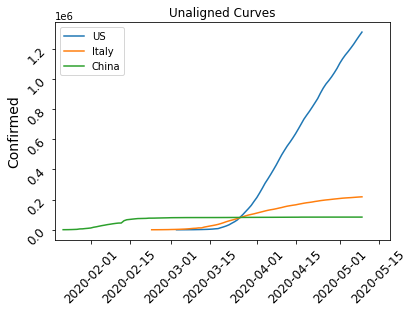

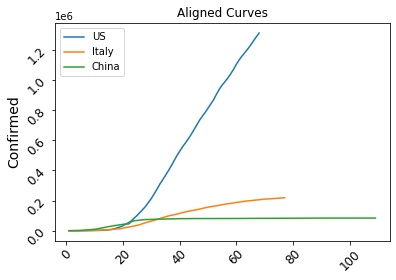

In [5]:
# Plotting the records of ['US', 'Italy','China'] with aligned outbreak date (from day 1 to current day)
for country in countries:
    dates=confirmed_selected[country].index
    plt.plot(np.array(list(confirmed_selected[country]['DayCount'].values)), np.array(list(confirmed_selected[country]['Cases'].values)), label=country)
    plt.legend(loc='upper left')
    plt.tick_params(rotation=45, labelsize=12)
    plt.ylabel('Confirmed', fontsize=14)
plt.xlim([np.array(list(confirmed_selected[country]['DayCount'].values))[0]-5, np.array(list(confirmed_selected[country]['DayCount'].values))[-1]+5])

plt.title('Aligned Curves')
plt.show()
##confirmed_selected

(-1000.0, 150000.0)

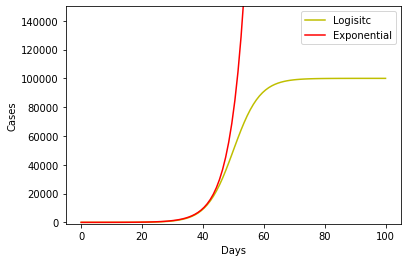

In [6]:
# Implementing the logistic and exponential models.

def logistic_model(x,a,b,n):
    '''the logistic model
    
        parameters
        ----------
        x: input day
        a: 1/growth rate
        b: inflection point
        n: possible max cases
        
        return
        log_model
    '''
    log_model = n/(1+np.exp(-(x-b)/a))
    return log_model
    ##
    
def exp_model(x,p,N0=3,X0=1):
    '''the logistic model

        parameters
        ----------
        x: input day
        p: growth rate
        N0: initial case for day 1
        X0: starting day
        
        return
            exp_model
    '''
    exp_model = N0*(1+p)**(x-X0)
    return exp_model
    ##

x= np.linspace(0,100,100) #input of the horizontal axis 
plt.plot(x, logistic_model(x,(1/0.23),50,100000), c='y', label='Logisitc')
plt.plot(x, exp_model(x, 0.23), c='r', label='Exponential')
##
plt.legend()
plt.xlabel('Days')
plt.ylabel('Cases')
plt.ylim(-1000,150000)

In [7]:
# Selecting US data and preparing the traing and test dataset
# US confirmed cases from the outbreak date
country = 'US'
print(confirmed_selected[country])

# training and test data
leaveout = -3 
x_train = np.array(list(confirmed_selected[country]['DayCount'].values))[:leaveout]
y_train = np.array(list(confirmed_selected[country]['Cases'].values))[:leaveout]    

x_test = np.array(list(confirmed_selected[country]['DayCount'].values))[leaveout:]
y_test = np.array(list(confirmed_selected[country]['Cases'].values))[leaveout:]

              Cases  DayCount
2020-03-03      118         1
2020-03-04      149         2
2020-03-05      217         3
2020-03-06      262         4
2020-03-07      402         5
...             ...       ...
2020-05-05  1204351        64
2020-05-06  1229331        65
2020-05-07  1257023        66
2020-05-08  1283929        67
2020-05-09  1309550        68

[68 rows x 2 columns]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [22]:
# Training the logistic model curve_fit in scipy.optimize
from scipy.optimize import curve_fit

print('Train the logistic model')
cf = curve_fit(logistic_model,x_train,y_train,p0=[3,20,5000], maxfev=10000)
a,b,n = cf[0]

print('a = '+'{:.3f}'.format(a))
print('b = '+'{:.3f}'.format(b))
print('n = '+'{:.3f}'.format(n))
##

Train the logistic model
a = 5.558
b = 35.721
n = 782518.760


In [23]:
import sklearn.metrics as sklm

# To calculate the mean squared log error, mean squared error and the R^2.
def my_evaluation(y, y_pred):
    mse = sklm.mean_squared_error(y, y_pred)
    mse_log = sklm.mean_squared_log_error(y, y_pred)
    r2 = sklm.r2_score(y, y_pred)
    ##
    return mse, mse_log, r2

# To calculate and print out the mse, mse_log and r2 for both the training and test sets.
    
y_pred_train = logistic_model(x_train, a, b, n)
mse_train, mse_log_train, r2_train = my_evaluation(y_train, y_pred_train)

y_pred_test = logistic_model(x_test, a, b, n)
mse_test, mse_log_test, r2_test = my_evaluation(y_test, y_pred_test)

print ('Training Set:- mse: {:.3f}, mse_log: {:.3f}, r2: {:.3f}'.format(mse_train, mse_log_train, r2_train))
print ('Test Set:- mse: {:.3f}, mse_log: {:.3f}, r2: {:.3f}'.format(mse_test, mse_log_test, r2_test))
##

Training Set:- mse: 69803592.590, mse_log: 1.157, r2: 0.999
Test Set:- mse: 3040134312.617, mse_log: 0.006, r2: -5.710


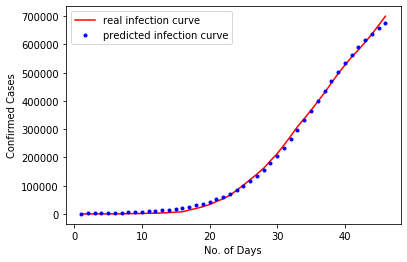

Estimated total number of cases: 782518


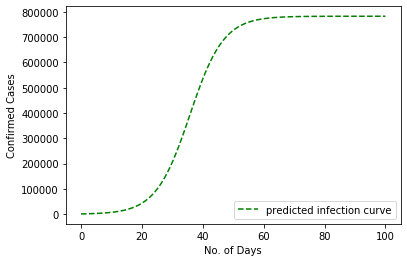

Predicted peak date:  04-29-2020


In [25]:
# Results visualization.
# The real infection curve vs. the predicted infection curve

plt.plot(x_train, y_train, '-',c='r', label = 'real infection curve')
plt.plot(x_train, y_pred_train, '.',c='b', label = 'predicted infection curve')

plt.xlabel('No. of Days')
plt.ylabel('Confirmed Cases')

plt.legend(loc='upper left') 
plt.show()


print ('Estimated total number of cases:', int(n))

x = np.linspace(0,100,100)
y = logistic_model(x, a, b, n)
plt.plot(x, y, '--', c='g',label = 'predicted infection curve')

plt.xlabel('No. of Days')
plt.ylabel('Confirmed Cases')

plt.legend(loc='lower right') 
plt.show()

perc_flat = 0.98
mdays = int(fsolve(lambda x : logistic_model(x,a,b,n) - perc_flat*int(n), b))
preddate = datetime.strftime(confirmed_selected[country].index[0] + timedelta(days=mdays), '%m-%d-%Y' )
print('Predicted peak date: ',preddate)

##

In [ ]:
'''
Q: When the US will reach the peak of COVID-19 cases?
A: 29, April 2020

Q: How many people are estimated to be infected in the US?
A: 782518

Q: Have we passed the inflection point？
A: No
'''